In [1]:
import cobra
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from beng213 import resources
from os.path import dirname, abspath
import escher

resource_dir = '../resources/'
map_loc = '%s/core_map_v17.json' % resource_dir
%matplotlib inline

# Solving book problems from Lehninger

In [2]:
builder = escher.Builder(map_json=map_loc)
builder

Builder()

## Chapter 14 problem 10
**Glycolysis Shortcut:** Suppose you discovered a mutant yeast whose glycolytic pathway was shorter because of the presence of a new enzyme catalyzing the reaction:

w/ metabolite names: `glyceraldehyde 3 phosphate + h2o + nad -> nadh + h + 2-phosphoglycerate`

w/ bigg ids: `g3p_c + h2o_c + nad_c -> nadh_c + h_c + 2pg_c`

**Approach**
1. Add reaction to core model
2. Plot maximum ATP production as a function of shortcut reaction activity


Text(0.5, 0, 'Shortcut flux')

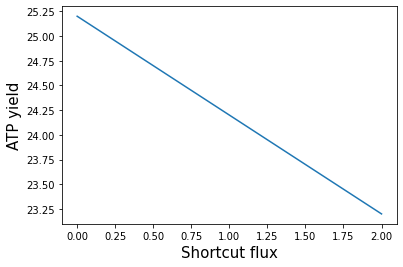

In [3]:
# Load Model
model = cobra.io.load_json_model('%s/core_model.json' % resource_dir)

# Add shortcut reaction
model.add_reaction(cobra.Reaction('shortcut'))
model.reactions.shortcut.build_reaction_from_string('g3p_c + h2o_c + nad_c -> nadh_c + h_c + 2pg_c')

# Assess ATP production ability
x = []
y = []
model.objective = 'ATPM'
for i in np.linspace(0, 2, 20): # Max flux through reaction is 2
    model.reactions.shortcut.lower_bound = i
    model.objective = 'ATPM'
    sol = model.optimize()
    x.append(i)
    y.append(sol.objective_value)
plt.plot(x, y)
plt.ylabel('ATP yield', size=15)
plt.xlabel('Shortcut flux', size=15)

## Chapter 16 problem 24

**Net Synthesis of $\alpha$-Ketoglutarate:** $\alpha$-Ketoglutarate plays a central role in the biosynthesis of several amino acids. Write a sequence of enzymatic reactions that could result in the net synthesis of $\alpha$-ketoglutarate from pyruvate. Your proposed sequence must not involve the net consumption of other citric acid cycle intermediates. 

**Approach**
1. Simulate the synthesis of $\alpha$-ketoglutarate from pyruvate and display the solutions on a flux map
 - Use `cobra.flux_analysis.pfba` to ensure a parsimonious flux state

In [6]:
# load model
model = cobra.io.load_json_model('%s/core_model.json' % resource_dir)

# add reaction for optimization
new_rxn = cobra.Reaction('DM_akg_m')
model.add_reaction(new_rxn)
new_rxn.add_metabolites({'akg_m': -1}) 

# set growth media
model.reactions.EX_pyr_c.lower_bound = -1
model.reactions.EX_glc__D_c.lower_bound = 0

# set objective and solve
model.objective = 'DM_akg_m'
sol = cobra.flux_analysis.pfba(model)

# display active reactions
filt = sol.to_frame()['fluxes'][abs(sol.to_frame()['fluxes']) > .1]
filt = filt.loc[[i for i in filt.index if  i[:3] not in ['DM_', 'EX_']]]
for i in filt.index:
    print(model.reactions.get_by_id(i))

CSm: accoa_m + h2o_m + oaa_m --> cit_m + coa_m + h_m
ACONTm: cit_m <=> icit_m
ICDHxm: icit_m + nad_m --> akg_m + co2_m + nadh_m
NADH2_u10mi: 5.0 h_m + nadh_m + q10_m --> 4.0 h_i + nad_m + q10h2_m
CYOR_u10mi: 2.0 ficytC_m + 2.0 h_m + q10h2_m --> 2.0 focytC_m + 4.0 h_i + q10_m
CYOOm2i: 4.0 focytC_m + 8.0 h_m + o2_m --> 4.0 ficytC_m + 2.0 h2o_m + 4.0 h_i
ATPS4mi: adp_m + 4.0 h_i + pi_m --> atp_m + h2o_m + 3.0 h_m
Htmi: h_i --> h_m
PDHm: coa_m + nad_m + pyr_m --> accoa_m + co2_m + nadh_m
PCm: atp_m + hco3_m + pyr_m --> adp_m + h_m + oaa_m + pi_m
HCO3Em: co2_m + h2o_m --> h_m + hco3_m
O2tm: o2_c <=> o2_m
H2Otm: h2o_c <=> h2o_m
CO2tm: co2_c <=> co2_m
PYRt2m: h_i + pyr_c --> h_m + pyr_m


In [7]:
builder = escher.Builder(map_json=map_loc, reaction_data=sol.to_frame()['fluxes'])
builder

Builder(reaction_data={'CSm': 0.5, 'ACONTm': 0.5, 'ICDHxm': 0.5, 'AKGDm': 0.0, 'SUCOASm': 0.0, 'SUCD1m': 0.0, …

## Chapter 14 problem 8

**Fermentation to Produce Soy Sauce**: Soy sauce is prepared by fermenting a salted mixture of soybeans and wheat with several microorganisms, including yeast, over a period of 8 to 12 months. The resulting sauce (after solids are removed) is rich in lactate and ethanol.

To prevent the soy sauce from having a strong vinegar taste (vinegar is dilute acetic acid), oxygen must be kept out of the fermentation tank. Why?

**Approach**
1. Add fermentation reactions to glycolysis model (from pyruvate)
 - Ethanol: PYRDC, ALCD2ir -- yeast reactions
 - Acetate: PDH, PTAr, ACKr -- e coli reactions
2. Knock out pyr_to_ATP reaction 
3. Fermentation is an adaptive mechanism to increase ATP yield. Restrict to one fermentation product and optimize for ATP
 - In aerobic and anaerobic conditions
4. Which fermentation byproduct results in the highest ATP yield in aerobic/anaerobic conditions?


In [8]:
# use the glycolysis model (it is well conserved)
glycolysis = cobra.io.load_json_model('%s/glycolysis_model.json' % resource_dir)
# can add the ethanol and acetate synthesis reactions from the yeast and e coli model
ecoli = cobra.io.load_json_model('%s/iML1515.json'  % resource_dir)
yeast = cobra.io.load_json_model('%s/iMM904.json'  % resource_dir)


In [10]:
glycolysis.reactions.EX_glc__D_c.lower_bound = -1
glycolysis.reactions.EX_o2_c.lower_bound = -1000
glycolysis.reactions.pyr_to_atp.knock_out()

# add ethanol fermentation
glycolysis.add_reaction(yeast.reactions.ALCD2ir)
glycolysis.add_reaction(yeast.reactions.PYRDC)

# add acetate fermentation
glycolysis.add_reaction(ecoli.reactions.PDH)
glycolysis.add_reaction(ecoli.reactions.PTAr)
glycolysis.add_reaction(ecoli.reactions.ACKr)

# add outlet for ethanol + acetate
for r_id, r in {'EX_ac_c': 'ac_c -> ', 'EX_etoh_c': 'etoh_c -> '}.items():
    r_obj = cobra.Reaction(r_id)
    glycolysis.add_reaction(r_obj)
    r_obj.build_reaction_from_string(r)
    

out_df = pd.DataFrame()
glycolysis.reactions.EX_ac_c.knock_out()
glycolysis.reactions.EX_lac__L_c.knock_out()
glycolysis.reactions.EX_etoh_c.knock_out()
glycolysis.objective = 'ATPM'
for ferm in ['EX_ac_c', 'EX_etoh_c', 'EX_lac__L_c']:
    with glycolysis:
        glycolysis.reactions.get_by_id(ferm).upper_bound = 1000

        out_df.loc[ferm, 'Aerobic ATP'] = glycolysis.optimize().objective_value

        glycolysis.reactions.EX_o2_c.lower_bound = 0
        out_df.loc[ferm, 'Anaerobic ATP'] = glycolysis.optimize().objective_value

out_df

,Aerobic ATP,Anaerobic ATP
EX_ac_c,14.0,1.554312e-15
EX_etoh_c,7.0,2.000000e+00
EX_lac__L_c,7.0,2.000000e+00


## Chapter 16 problem 30
Although oxygen does not participate directly
in the citric acid cycle, the cycle operates only when O2 is
present. Why?

Text(0, 0.5, 'TCA activity (Citrate synthase)')

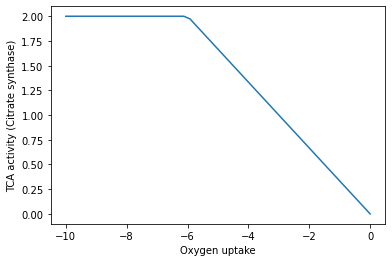

In [11]:
model = cobra.io.load_json_model('%s/core_model.json' % resource_dir)
tca = []
oxygen = np.linspace(-10, 0)
for lb in oxygen:
    model.reactions.EX_o2_c.lower_bound = lb
    sol = model.optimize()
    tca.append(sol.fluxes['CSm'])
    
plt.plot(oxygen, tca)
plt.xlabel('Oxygen uptake')
plt.ylabel('TCA activity (Citrate synthase)')

## Chapter 16 problem 23
**Synthesis of L-Malate in Wine Making:** The tartness of some wines is due to high concentrations of L-malate. Write a sequence of reactions showing how yeast cells synthesize L-malate from glucose under anaerobic conditions in the presence of dissolved CO2 (HCO3 ). Note that the overall reaction for this fermentation cannot involve the consumption of nicotinamide coenzymes or citric acid cycle intermediates.

**Approach**
1. Ensure that all biosynthetic intermediates of malate can be synthesized in the cytosol
 - If not use bigg to find a reaction in yeast that can fulfill role
2. Optimize anaerobically to get net equation


In [12]:
model = cobra.io.load_json_model('%s/core_model.json' % resource_dir)
model.add_reaction(cobra.Reaction("PC"))
model.reactions.PC.build_reaction_from_string('atp_c + hco3_c + pyr_c -> adp_c + h_c + oaa_c + pi_c')
model.add_boundary(model.metabolites.mal__L_c)
model.reactions.EX_glc__D_c.lower_bound =-1
model.reactions.EX_o2_c.lower_bound = 0
model.reactions.EX_co2_c.lower_bound = -100
model.objective = 'EX_mal__L_c'
sol = model.optimize()

df = pd.DataFrame()
for r in model.reactions:
    if 'EX_' in r.id and abs(r.flux) > .01:
        df.loc[r.id, 'Exchange'] = r.flux
        print(r.id + ':', r.flux)
    elif abs(r.flux) > .01:
        print(r, r.flux)

HEX1: atp_c + glc__D_c --> adp_c + g6p_c + h_c 1.0
PGI: g6p_c <=> f6p_c 1.0000000000000002
PFK: atp_c + f6p_c --> adp_c + fdp_c + h_c 1.0000000000000002
FBA: fdp_c <=> dhap_c + g3p_c 1.0000000000000002
TPI: dhap_c <=> g3p_c 1.0000000000000002
GAPD: g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c 2.000000000000001
PGK: 3pg_c + atp_c <=> 13dpg_c + adp_c -2.000000000000001
PGM: 2pg_c <=> 3pg_c -2.0000000000000004
ENO: 2pg_c <=> h2o_c + pep_c 2.0
PYK: adp_c + h_c + pep_c --> atp_c + pyr_c 2.0
MDH: mal__L_c + nad_c <=> h_c + nadh_c + oaa_c -2.0000000000000036
HCO3E: co2_c + h2o_c <=> h_c + hco3_c 2.0
EX_h_c: 4.0
EX_glc__D_c: -1.0
EX_co2_c: -2.0000000000000004
PC: atp_c + hco3_c + pyr_c --> adp_c + h_c + oaa_c + pi_c 2.000000000000001
EX_mal__L_c: 2.0000000000000027


### Chapter 17 problem 23 (modified)

**$\beta$ Oxidation of Caprylic acid:** How many turns of the TCA cycle are required to fully oxidize the acetyl-CoA generated in $\beta$ oxidation of 1 mol of Caprylic acid? How many ATP can be generated from 1 mol of Caprylic acid

**Hint**: uptake for Caprylic acid is `EX_octa_c`

In [4]:
model = cobra.io.load_json_model('%s/core_model.json' % resource_dir)
model.reactions.EX_octa_c.lower_bound = -1
model.reactions.EX_glc__D_c.lower_bound = 0
sol = model.optimize()
print(round(sol.fluxes['CSm'], 2))

4.0
